Looking at team performance, using subjective daily data. This notebook does the analysis in "daily" level. That is, we look at each day separately

In [1]:
from __future__ import absolute_import, division, print_function
import datetime

import pandas as pd
import scipy.stats  as stats
from scipy import special
import numpy as np

import statsmodels.api as sm

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
import imgkit


import sys
sys.path.insert(0, '../../../src/data/')

from config import *
from analysis_connections import generate_analysis_connections_store_key

2019-02-13 18:35:19,952 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


# General prep

## Load daily survey data

In [2]:
daily_survey_data_clean = pd.read_hdf(surveys_clean_store_path, 'daily/daily_survey_data_clean')
daily_survey_data_clean = daily_survey_data_clean.reset_index()

## Load panels

In [3]:
company_panel = pd.read_hdf(analysis_notebooks_store_path, 'panels/company_panel')
members_panel = pd.read_hdf(analysis_notebooks_store_path, 'panels/members_panel')

# Daily - prep

## Aggregate company level interaction

In [4]:
store_key = generate_analysis_connections_store_key(-62,'c2c_dbl_daily')
c2c_dbl_daily_62 = pd.read_hdf(analysis_store_path, store_key)
c2c_dbl_daily_62.reset_index(inplace=True)

In [5]:
# Aggregate by company
company_dyads_daily_minutes = c2c_dbl_daily_62[c2c_dbl_daily_62.company1 == c2c_dbl_daily_62.company2]
company_dyads_daily_minutes = company_dyads_daily_minutes.rename(
    columns={'minutes':'minutes_62','company1':'company'}
)
del company_dyads_daily_minutes['company2']

In [6]:
# Add normalized columns
columns_to_normalize = ['minutes_62']
company_dyads_daily_minutes = company_dyads_daily_minutes.join(company_panel[['members_count','dyads_count']], on='company')

for c in columns_to_normalize:
    company_dyads_daily_minutes[c+"_norm_members"]=company_dyads_daily_minutes[c]/company_dyads_daily_minutes['members_count']
    company_dyads_daily_minutes[c+"_norm_dyads"]=company_dyads_daily_minutes[c]/company_dyads_daily_minutes['dyads_count']

company_dyads_daily_minutes = company_dyads_daily_minutes.set_index(['datetime','company'])    

del company_dyads_daily_minutes['members_count']
del company_dyads_daily_minutes['dyads_count']

company_dyads_daily_minutes.head()

minutes_62  minutes_62_norm_members  \
datetime                  company                                          
2018-06-12 00:00:00-04:00 Company A      530.00               132.500000   
                          Company E       47.50                23.750000   
                          Company F      104.75                34.916667   
                          Company G      283.50                70.875000   
                          Company I       68.50                17.125000   

                                     minutes_62_norm_dyads  
datetime                  company                           
2018-06-12 00:00:00-04:00 Company A              88.333333  
                          Company E              47.500000  
                          Company F              34.916667  
                          Company G              47.250000  
                          Company I              11.416667

## Intra team communication

In [7]:
c2c_daily_out_62 = c2c_dbl_daily_62.copy()

# cleanup 
companies_to_exclude = ['Company Q','Company J','Staff','EIR']
c2c_daily_out_62 = c2c_daily_out_62.loc[~c2c_daily_out_62.company2.isin(companies_to_exclude)]
c2c_daily_out_62 = c2c_daily_out_62.loc[~c2c_daily_out_62.company1.isin(companies_to_exclude)]
c2c_daily_out_62 = c2c_daily_out_62.loc[c2c_daily_out_62.company1 != c2c_daily_out_62.company2]

c2c_daily_out_62 = c2c_daily_out_62.rename(columns={'minutes':'minutes_out_62'})
c2c_daily_out_62 = c2c_daily_out_62.rename(columns={'company1':'company'})

# groupby
c2c_daily_out_62 = c2c_daily_out_62\
    .set_index(['datetime','company'])['minutes_out_62']\
    .groupby(['datetime','company']).agg(['sum'])\
    .rename(columns={'sum':'minutes_out_62'})

#    .groupby(['datetime','company']).agg(['sum'])\#,'mean','var','std'])\
#    .rename(columns={'sum':'minutes_out_62'})#,'mean':'minutes_out_62_c2c_mean','var':'minutes_out_62_c2c_var','std':'minutes_out_62_c2c_std'})


In [8]:
print(len(c2c_daily_out_62))

429


In [9]:
# Add normalized columns
columns_to_normalize = ['minutes_out_62']
c2c_daily_out_62 = c2c_daily_out_62.join(company_panel[['members_count','dyads_count']])

for c in columns_to_normalize:
    c2c_daily_out_62[c+"_norm_members"]=c2c_daily_out_62[c]/c2c_daily_out_62['members_count']
    c2c_daily_out_62[c+"_norm_dyads"]=c2c_daily_out_62[c]/c2c_daily_out_62['dyads_count']


In [10]:
del c2c_daily_out_62['dyads_count']
del c2c_daily_out_62['members_count']

## EIR/Staff communication

In [11]:
c2c_daily_eir_62 = c2c_dbl_daily_62.copy()

# cleanup 
companies_to_include = ['EIR']
c2c_daily_eir_62 = c2c_daily_eir_62.loc[c2c_daily_eir_62.company2.isin(companies_to_exclude)]

c2c_daily_eir_62 = c2c_daily_eir_62.rename(columns={'minutes':'minutes_eir_62'})
c2c_daily_eir_62 = c2c_daily_eir_62.rename(columns={'company1':'company'})

# groupby
c2c_daily_eir_62 = c2c_daily_eir_62\
    .set_index(['datetime','company'])['minutes_eir_62']\
    .groupby(['datetime','company']).agg(['sum'])\
    .rename(columns={'sum':'minutes_eir_62'})


In [12]:
# Add normalized columns
columns_to_normalize = ['minutes_eir_62']
c2c_daily_eir_62 = c2c_daily_eir_62.join(company_panel[['members_count','dyads_count']])

for c in columns_to_normalize:
    c2c_daily_eir_62[c+"_norm_members"]=c2c_daily_eir_62[c]/c2c_daily_eir_62['members_count']
    c2c_daily_eir_62[c+"_norm_dyads"]=c2c_daily_eir_62[c]/c2c_daily_eir_62['dyads_count']


In [13]:
c2c_daily_eir_62.head()

minutes_eir_62  members_count  \
datetime                  company                                    
2018-06-12 00:00:00-04:00 Company A           486.0            4.0   
                          Company B            60.0            4.0   
                          Company E           134.0            2.0   
                          Company F           251.0            3.0   
                          Company G           357.0            4.0   

                                     dyads_count  minutes_eir_62_norm_members  \
datetime                  company                                               
2018-06-12 00:00:00-04:00 Company A          6.0                   121.500000   
                          Company B          6.0                    15.000000   
                          Company E          1.0                    67.000000   
                          Company F          3.0                    83.666667   
                          Company G          6.0                    89.250000   

                                     minutes_eir_62_norm_dyads  
datetime                  company                               
2018-06-12 00:00:00-04:00 Company A                  81.000000  
                          Company B                  10.000000  
                          Company E                 134.000000  
                          Company F                  83.666667  
                          Company G                  59.500000

## Agg survey data

Calculate regular means

In [14]:
company_daily_survey_agg_daily = daily_survey_data_clean.join(members_panel['company'], on='member') \
    .groupby(['effective_ts','company'])[['Q1','Q2']].agg(['min','max','mean','var','std','count'])
company_daily_survey_agg_daily.columns = ["_".join(x) for x in company_daily_survey_agg_daily.columns.ravel()]

In [15]:
company_daily_survey_agg_daily.head()

Q1_min  Q1_max   Q1_mean    Q1_var  \
effective_ts              company                                         
2018-06-13 00:00:00-04:00 Company A     4.0     6.0  5.333333  1.333333   
                          Company B     4.0     4.0  4.000000       NaN   
                          Company C     4.0     6.0  5.333333  1.333333   
                          Company E     6.0     6.0  6.000000  0.000000   
                          Company F     5.0     6.0  5.500000  0.500000   

                                       Q1_std  Q1_count  Q2_min  Q2_max  \
effective_ts              company                                         
2018-06-13 00:00:00-04:00 Company A  1.154701         3     5.0     6.0   
                          Company B       NaN         1     4.0     4.0   
                          Company C  1.154701         3     6.0     7.0   
                          Company E  0.000000         2     5.0     6.0   
                          Company F  0.707107         2     5.0     6.0   

                                      Q2_mean    Q2_var    Q2_std  Q2_count  
effective_ts              company                                            
2018-06-13 00:00:00-04:00 Company A  5.666667  0.333333  0.577350         3  
                          Company B  4.000000       NaN       NaN         1  
                          Company C  6.333333  0.333333  0.577350         3  
                          Company E  5.500000  0.500000  0.707107         2  
                          Company F  5.500000  0.500000  0.707107         2

## Combine

In [16]:
company_dyads_daily_full = pd.merge(
    company_daily_survey_agg_daily.reset_index(), company_dyads_daily_minutes.reset_index()
    ,left_on=['company','effective_ts']
    ,right_on=['company','datetime']
    ,how='left')    
del company_dyads_daily_full['datetime']


# Null minutes are 0 minutes
columns_to_fill = company_dyads_daily_minutes.columns
company_dyads_daily_full[columns_to_fill] = company_dyads_daily_full[columns_to_fill].fillna(0)

In [17]:
company_dyads_daily_full = pd.merge(
    company_dyads_daily_full.reset_index(), c2c_daily_out_62.reset_index()
    ,left_on=['company','effective_ts']
    ,right_on=['company','datetime']
    ,how='left')    
del company_dyads_daily_full['datetime']

# Null minutes are 0 minutes
columns_to_fill = c2c_daily_out_62.columns
company_dyads_daily_full[columns_to_fill] = company_dyads_daily_full[columns_to_fill].fillna(0)

In [18]:
company_dyads_daily_full = pd.merge(
    company_dyads_daily_full.reset_index(), c2c_daily_eir_62.reset_index()
    ,left_on=['company','effective_ts']
    ,right_on=['company','datetime']
    ,how='left')    
del company_dyads_daily_full['datetime']

# Null minutes are 0 minutes
columns_to_fill = c2c_daily_eir_62.columns
company_dyads_daily_full[columns_to_fill] = company_dyads_daily_full[columns_to_fill].fillna(0)

In [19]:
company_dyads_daily_full.head()

,level_0,index,effective_ts,company,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q1_count,...,minutes_62_norm_members,minutes_62_norm_dyads,minutes_out_62,minutes_out_62_norm_members,minutes_out_62_norm_dyads,minutes_eir_62,members_count,dyads_count,minutes_eir_62_norm_members,minutes_eir_62_norm_dyads
0,0,0,2018-06-13 00:00:00-04:00,Company A,4.0,6.0,5.333333,1.333333,1.154701,3,...,62.812500,41.875000,534.50,133.6250,89.083333,110.50,4.0,6.0,27.6250,18.416667
1,1,1,2018-06-13 00:00:00-04:00,Company B,4.0,4.0,4.000000,NaN,NaN,1,...,0.000000,0.000000,48.25,12.0625,8.041667,23.25,4.0,6.0,5.8125,3.875000
2,2,2,2018-06-13 00:00:00-04:00,Company C,4.0,6.0,5.333333,1.333333,1.154701,3,...,87.937500,58.625000,404.25,101.0625,67.375000,122.75,4.0,6.0,30.6875,20.458333
3,3,3,2018-06-13 00:00:00-04:00,Company E,6.0,6.0,6.000000,0.000000,0.000000,2,...,58.625000,117.250000,271.75,135.8750,271.750000,116.25,2.0,1.0,58.1250,116.250000
4,4,4,2018-06-13 00:00:00-04:00,Company F,5.0,6.0,5.500000,0.500000,0.707107,2,...,37.833333,37.833333,126.75,42.2500,42.250000,21.00,3.0,3.0,7.0000,7.000000


In [20]:
df = company_dyads_daily_full
print(len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)]

55


,level_0,index,effective_ts,company,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q1_count,...,minutes_62_norm_members,minutes_62_norm_dyads,minutes_out_62,minutes_out_62_norm_members,minutes_out_62_norm_dyads,minutes_eir_62,members_count,dyads_count,minutes_eir_62_norm_members,minutes_eir_62_norm_dyads
1,1,1,2018-06-13 00:00:00-04:00,Company B,4.0,4.0,4.0,NaN,NaN,1,...,0.000000,0.000000,48.25,12.062500,8.041667,23.25,4.0,6.0,5.812500,3.875000
10,10,10,2018-06-13 00:00:00-04:00,Company M,6.0,6.0,6.0,NaN,NaN,1,...,54.125000,36.083333,369.50,92.375000,61.583333,155.00,4.0,6.0,38.750000,25.833333
26,26,26,2018-06-14 00:00:00-04:00,Company M,6.0,6.0,6.0,NaN,NaN,1,...,44.375000,29.583333,363.75,90.937500,60.625000,108.75,4.0,6.0,27.187500,18.125000
50,50,50,2018-06-18 00:00:00-04:00,Company D,4.0,4.0,4.0,NaN,NaN,1,...,33.750000,67.500000,33.25,16.625000,33.250000,32.00,2.0,1.0,16.000000,32.000000
63,63,63,2018-06-18 00:00:00-04:00,Company R,5.0,5.0,5.0,NaN,NaN,1,...,9.125000,18.250000,75.00,37.500000,75.000000,33.50,2.0,1.0,16.750000,33.500000
74,74,74,2018-06-19 00:00:00-04:00,Company J,6.0,6.0,6.0,NaN,NaN,1,...,0.000000,0.000000,0.00,0.000000,0.000000,1.25,2.0,1.0,0.625000,1.250000
82,82,82,2018-06-19 00:00:00-04:00,Company R,7.0,7.0,7.0,NaN,NaN,1,...,28.750000,57.500000,14.75,7.375000,14.750000,4.50,2.0,1.0,2.250000,4.500000
93,93,93,2018-06-20 00:00:00-04:00,Company J,7.0,7.0,7.0,NaN,NaN,1,...,0.000000,0.000000,0.00,0.000000,0.000000,73.75,2.0,1.0,36.875000,73.750000
101,101,101,2018-06-20 00:00:00-04:00,Company R,6.0,6.0,6.0,NaN,NaN,1,...,11.000000,22.000000,11.00,5.500000,11.000000,1.50,2.0,1.0,0.750000,1.500000
112,112,112,2018-06-21 00:00:00-04:00,Company J,6.0,6.0,6.0,NaN,NaN,1,...,0.000000,0.000000,0.00,0.000000,0.000000,46.25,2.0,1.0,23.125000,46.250000


In [21]:
print(len(df))

448


## Clean

Remove company Q, remove J

In [22]:
print(len(company_dyads_daily_full))
company_dyads_daily_full_clean = company_dyads_daily_full.query('company not in ("Company Q","Company J")').copy()
print(len(company_dyads_daily_full_clean))
#company_dyads_daily_full_clean = company_dyads_daily_full_clean.dropna()

448
416


Remove companies with only 2 members? (do it's comparable to the other analysis?)

In [23]:
#company_dyads_daily_full_clean = company_dyads_daily_full_clean.query('company not in ("Company D","Company E","Company R")').copy()

In [24]:
print(len(company_dyads_daily_full_clean.company.value_counts()))

17


In [25]:
company_dyads_daily_full_clean

,level_0,index,effective_ts,company,Q1_min,Q1_max,Q1_mean,Q1_var,Q1_std,Q1_count,...,minutes_62_norm_members,minutes_62_norm_dyads,minutes_out_62,minutes_out_62_norm_members,minutes_out_62_norm_dyads,minutes_eir_62,members_count,dyads_count,minutes_eir_62_norm_members,minutes_eir_62_norm_dyads
0,0,0,2018-06-13 00:00:00-04:00,Company A,4.0,6.0,5.333333,1.333333,1.154701,3,...,62.812500,41.875000,534.50,133.625000,89.083333,110.50,4.0,6.0,27.625000,18.416667
1,1,1,2018-06-13 00:00:00-04:00,Company B,4.0,4.0,4.000000,NaN,NaN,1,...,0.000000,0.000000,48.25,12.062500,8.041667,23.25,4.0,6.0,5.812500,3.875000
2,2,2,2018-06-13 00:00:00-04:00,Company C,4.0,6.0,5.333333,1.333333,1.154701,3,...,87.937500,58.625000,404.25,101.062500,67.375000,122.75,4.0,6.0,30.687500,20.458333
3,3,3,2018-06-13 00:00:00-04:00,Company E,6.0,6.0,6.000000,0.000000,0.000000,2,...,58.625000,117.250000,271.75,135.875000,271.750000,116.25,2.0,1.0,58.125000,116.250000
4,4,4,2018-06-13 00:00:00-04:00,Company F,5.0,6.0,5.500000,0.500000,0.707107,2,...,37.833333,37.833333,126.75,42.250000,42.250000,21.00,3.0,3.0,7.000000,7.000000
5,5,5,2018-06-13 00:00:00-04:00,Company G,5.0,7.0,6.000000,0.666667,0.816497,4,...,237.312500,158.208333,472.25,118.062500,78.708333,100.00,4.0,6.0,25.000000,16.666667
6,6,6,2018-06-13 00:00:00-04:00,Company H,4.0,5.0,4.500000,0.500000,0.707107,2,...,7.916667,7.916667,64.75,21.583333,21.583333,7.00,3.0,3.0,2.333333,2.333333
7,7,7,2018-06-13 00:00:00-04:00,Company I,5.0,6.0,5.500000,0.500000,0.707107,2,...,14.125000,9.416667,166.50,41.625000,27.750000,6.25,4.0,6.0,1.562500,1.041667
8,8,8,2018-06-13 00:00:00-04:00,Company K,4.0,6.0,5.333333,1.333333,1.154701,3,...,175.250000,175.250000,553.00,184.333333,184.333333,128.00,3.0,3.0,42.666667,42.666667
9,9,9,2018-06-13 00:00:00-04:00,Company L,5.0,5.0,5.000000,0.000000,0.000000,3,...,136.166667,136.166667,608.50,202.833333,202.833333,105.00,3.0,3.0,35.000000,35.000000


## Add percentile

In [26]:
percentiles = 3
company_dyads_daily_full_clean['minutes_62_p']              = pd.qcut(company_dyads_daily_full_clean['minutes_62'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_62_norm_members_p'] = pd.qcut(company_dyads_daily_full_clean['minutes_62_norm_members'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_62_norm_dyads_p']   = pd.qcut(company_dyads_daily_full_clean['minutes_62_norm_dyads'], percentiles, labels=False)

company_dyads_daily_full_clean['minutes_out_62_p']              = pd.qcut(company_dyads_daily_full_clean['minutes_out_62'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_out_62_norm_members_p'] = pd.qcut(company_dyads_daily_full_clean['minutes_out_62_norm_members'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_out_62_norm_dyads_p']   = pd.qcut(company_dyads_daily_full_clean['minutes_out_62_norm_dyads'], percentiles, labels=False)

company_dyads_daily_full_clean['minutes_eir_62_p']              = pd.qcut(company_dyads_daily_full_clean['minutes_eir_62'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_eir_62_norm_members_p'] = pd.qcut(company_dyads_daily_full_clean['minutes_eir_62_norm_members'], percentiles, labels=False)
company_dyads_daily_full_clean['minutes_eir_62_norm_dyads_p']   = pd.qcut(company_dyads_daily_full_clean['minutes_eir_62_norm_dyads'], percentiles, labels=False)


## Save for other notebooks

In [27]:
with pd.HDFStore(analysis_notebooks_store_path ) as store:
    store.put('team_performance/company_dyads_daily_full_clean', company_dyads_daily_full_clean)

# Explore - intra team

In [28]:
pairplot_columns = ['minutes_62','minutes_62_norm_members','minutes_62_norm_dyads','minutes_62_p','minutes_62_norm_members_p','minutes_62_norm_dyads_p']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std']+pairplot_columns

### Scatter plots

In [29]:
def corr_figure(data, question_column, minutes_column, title,ax):
    df_clean = data.copy().query(minutes_column + "==" +minutes_column)
    if len(df_clean) != len (data):
        raise Exception('Data contains nulls')        
    (c,p) = stats.pearsonr(data[question_column], data[minutes_column])
    c_str = "{:.3f}".format(c)
    p_str = "{:.3f}".format(p)
    
    plt = sns.scatterplot(x=minutes_column, y=question_column, ax=ax,
    data=data,color="blue", legend=False, hue="company")#, hue="company", palette=sns.dark_palette("purple", n_colors=19))
    
    ax.set_title(title+"\n(Correlation: "+c_str+", p-value: "+p_str+")")
    
def plot_corr(data, question_column_postfix, minutes_column, title):
    #c = data[question_column].corr(data[minutes_column])
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))
   
    corr_figure(data,"Q1"+question_column_postfix,minutes_column,"Question 1, "+title,ax)
    corr_figure(data,"Q2"+question_column_postfix,minutes_column,"Question 2, "+title,ax2)
    
    
    #df2["b"].plot(kind='barh', x='LABEL',ax=ax2)
    plt.show()

2019-02-13 18:35:23,249 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-02-13 18:35:23,550 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


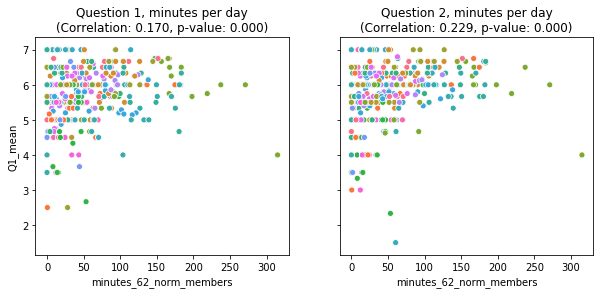

In [30]:
plot_corr(company_dyads_daily_full_clean,"_mean","minutes_62_norm_members","minutes per day")

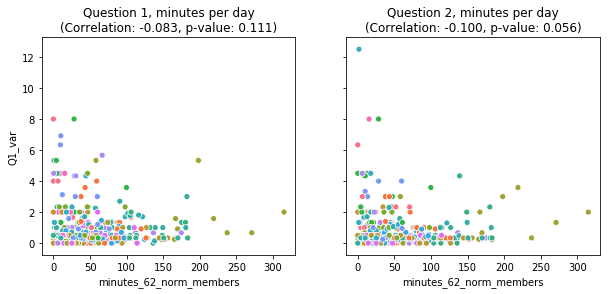

In [31]:
plot_corr(company_dyads_daily_full_clean.dropna(),"_var","minutes_62_norm_members","minutes per day")

### Correlations

In [32]:
#plot_corr(company_dyads_annual_full_clean.reset_index(), "_mean","minutes_62_m2m_entropy","LALAL")

In [33]:
div_cmap = sns.diverging_palette(220, 10, n=9, as_cmap=True)

def colfix(df, L=5): return df.rename(columns=lambda x: ' '.join(x.replace('_', ' ')[i:i+L] for i in range(0,len(x),L)) if df[x].dtype in ['float64','int64'] else x )

def create_style_corr_table(df, cmap=div_cmap):
    s = df
    s = colfix(s, 10)
    s = s.corr().style
    s.background_gradient(cmap=cmap, axis=1)
    s.set_precision(2)
    s.set_table_styles([dict(selector="th",props=[('max-width', '80px')])])
    return s

def plot_corr_martix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),  cmap=div_cmap,
            square=True, ax=ax)

In [34]:
s = create_style_corr_table(company_dyads_daily_full_clean[q1_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q1_corr_daily.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q1 mean,Q1 min,Q1 var,Q1 std,minutes 62,minutes 62 norm memb ers,minutes 62 norm dyad s,minutes 62 p,minutes 62 norm memb ers p,minutes 62 norm dyad s p
Q1 mean,1,0.81,-0.36,-0.36,0.19,0.17,0.09,0.23,0.21,0.078
Q1 min,0.81,1,-0.71,-0.75,-0.043,0.0011,0.042,-0.01,0.022,0.024
Q1 var,-0.36,-0.71,1,0.92,-0.066,-0.082,-0.11,-0.1,-0.13,-0.14
Q1 std,-0.36,-0.75,0.92,1,0.016,-0.015,-0.078,-0.025,-0.066,-0.1
minutes 62,0.19,-0.043,-0.066,0.016,1,0.9,0.62,0.81,0.78,0.54
minutes 62 norm memb ers,0.17,0.0011,-0.082,-0.015,0.9,1,0.88,0.79,0.81,0.72
minutes 62 norm dyad s,0.09,0.042,-0.11,-0.078,0.62,0.88,1,0.6,0.7,0.78
minutes 62 p,0.23,-0.01,-0.1,-0.025,0.81,0.79,0.6,1,0.89,0.64
minutes 62 norm memb ers p,0.21,0.022,-0.13,-0.066,0.78,0.81,0.7,0.89,1,0.81
minutes 62 norm dyad s p,0.078,0.024,-0.14,-0.1,0.54,0.72,0.78,0.64,0.81,1


In [35]:
s = create_style_corr_table(company_dyads_daily_full_clean[q2_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q2_corr_daily.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q2 mean,Q2 min,Q2 var,Q2 std,minutes 62,minutes 62 norm memb ers,minutes 62 norm dyad s,minutes 62 p,minutes 62 norm memb ers p,minutes 62 norm dyad s p
Q2 mean,1,0.84,-0.39,-0.38,0.22,0.23,0.17,0.29,0.27,0.16
Q2 min,0.84,1,-0.68,-0.74,0.034,0.076,0.1,0.094,0.12,0.13
Q2 var,-0.39,-0.68,1,0.91,-0.11,-0.1,-0.098,-0.16,-0.19,-0.18
Q2 std,-0.38,-0.74,0.91,1,-0.035,-0.044,-0.073,-0.091,-0.14,-0.18
minutes 62,0.22,0.034,-0.11,-0.035,1,0.9,0.62,0.81,0.78,0.54
minutes 62 norm memb ers,0.23,0.076,-0.1,-0.044,0.9,1,0.88,0.79,0.81,0.72
minutes 62 norm dyad s,0.17,0.1,-0.098,-0.073,0.62,0.88,1,0.6,0.7,0.78
minutes 62 p,0.29,0.094,-0.16,-0.091,0.81,0.79,0.6,1,0.89,0.64
minutes 62 norm memb ers p,0.27,0.12,-0.19,-0.14,0.78,0.81,0.7,0.89,1,0.81
minutes 62 norm dyad s p,0.16,0.13,-0.18,-0.18,0.54,0.72,0.78,0.64,0.81,1


### Compare populations

In [36]:
# Mann–Whitney U test
'''
def compare_groups(data, column):
    group_a = data.query(column+' == 0')
    group_b = data.query(column+' == 1')
    print("")

    test_function = stats.mannwhitneyu
    #test_function = stats.ks_2samp

    q_columns_to_test = ['_mean','_var']
    print("Group sizes: ",",",len(group_a),",",len(group_b))

    for q in range (1,3):
        for c in q_columns_to_test:
            question_column = 'Q'+str(q)+c
            print("------------------------")
            print(q,question_column)
            stat, p = test_function(group_a[question_column], group_b[question_column]) # low p-value = different        
            ma = group_a[question_column].mean()
            mb = group_b[question_column].mean()
            print("p: {:.2f}, Means: {:.2f},{:.2f}".format(p,ma,mb))
'''

'\ndef compare_groups(data, column):\n    group_a = data.query(column+\' == 0\')\n    group_b = data.query(column+\' == 1\')\n    print("")\n\n    test_function = stats.mannwhitneyu\n    #test_function = stats.ks_2samp\n\n    q_columns_to_test = [\'_mean\',\'_var\']\n    print("Group sizes: ",",",len(group_a),",",len(group_b))\n\n    for q in range (1,3):\n        for c in q_columns_to_test:\n            question_column = \'Q\'+str(q)+c\n            print("------------------------")\n            print(q,question_column)\n            stat, p = test_function(group_a[question_column], group_b[question_column]) # low p-value = different        \n            ma = group_a[question_column].mean()\n            mb = group_b[question_column].mean()\n            print("p: {:.2f}, Means: {:.2f},{:.2f}".format(p,ma,mb))\n'

In [37]:
# Mann–Whitney U test
def compare_groups(data,question_column_postfix, column, g1,g2,test="mw"):
    """
    column - percentile/tertile/quartile column to use
    g1 - percentile values for the first group
    g2 - same for second group
    """
    print(data[column].value_counts())
    group_a = data.loc[data[column].isin(g1)]
    group_b = data.loc[data[column].isin(g2)] 

    if test == "mw":
        test_function = stats.mannwhitneyu
    elif test == "ttest":
        test_function = stats.ttest_ind
    elif test == "ks":
        test_function = stats.ks_2samp
    elif test =="wmw":
        test_function = stats.wilcoxon
    else:
        return

    print("Test: "+str(test_function))

    q_columns_to_test = ['_mean','_var']#,'_mean_daily_var']
    print("Group sizes: ",",",len(group_a),",",len(group_b))

    columns=[]
    for q in range (1,3):
            question_column = 'Q'+str(q)+question_column_postfix
            columns.append(question_column)
            stat, p = test_function(group_a[question_column], group_b[question_column]) # low p-value = different        
            ma = group_a[question_column].mean()
            sema = group_a[question_column].sem()
            mia= group_a[question_column].median()
            mb = group_b[question_column].mean()
            semb = group_b[question_column].sem()
            mib= group_b[question_column].median()
            
            ks_stat1, ks_p1 = stats.kstest(group_a[question_column], 'norm')
            ks_stat2, ks_p2 = stats.kstest(group_b[question_column], 'norm')
            
            print("Q{}, p: {:.2f}, Means: {:.2f} ({:.2f}),{:.2f} ({:.2f}), medians: {:.2f},{:.2f}".format(q, p,ma,sema,mb,semb,mia,mib))
            #stats.probplot(group_a[question_column],plot=plt)
            #plt.show()
            #group_a[question_column].hist(bins=20)
            #plt.show()
            #stats.probplot(group_b[question_column],plot=plt)
            #plt.show()
            #group_b[question_column].hist(bins=20)
            #plt.show()

            print("--- KS test - Q{}: group a: {:.2f}   group b: {:.2f}".format(q,ks_p1,ks_p2)) #p <= alpha: reject H0, not normal.
            
    ax = data.boxplot(column=columns, by=column, figsize=(10,4),  showfliers=False, grid=False, showmeans=True)
    plt.show()
    
    

KstestResult(statistic=0.9937903346742238, pvalue=0.0)


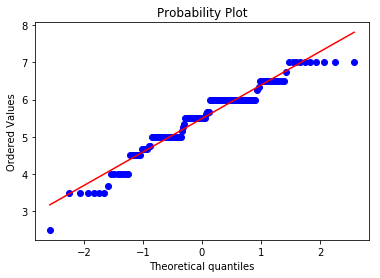

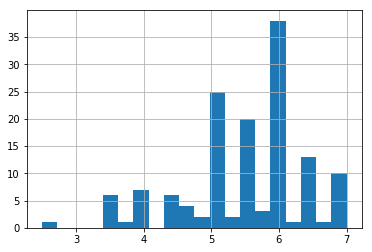

In [38]:
group_a = company_dyads_daily_full_clean.loc[company_dyads_daily_full_clean['minutes_62_norm_members_p'].isin([0])].copy()
group_a['Q1_mean_round'] = np.round(group_a['Q1_mean'])
question_column = 'Q1_mean'
print(stats.kstest(group_a[question_column], 'norm'))
#print(len(group_a))
#sm.qqplot(group_a[question_column], line='45')
#plt.show()
stats.probplot(group_a[question_column],plot=plt)
plt.show()
group_a[question_column].hist(bins=20)
#plt.show()
#print(group_a[question_column].value_counts())

2    136
1    130
0    101
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 101 , 136
Q1, p: 0.00, Means: 5.42 (0.09),5.91 (0.05), medians: 5.50,6.00
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.00, Means: 5.45 (0.09),6.06 (0.05), medians: 5.50,6.00
--- KS test - Q2: group a: 0.00   group b: 0.00


/home/orenled/Envs/rhythm-private-analysis-deltav18-anon/lib/python2.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


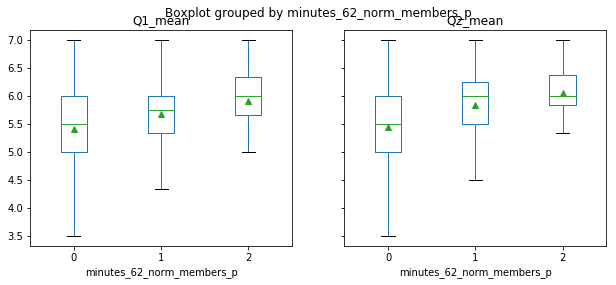

In [39]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_mean", 'minutes_62_norm_members_p',[0],[2])

2    136
1    130
0    101
Name: minutes_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 101 , 136
Q1, p: 0.13, Means: 1.32 (0.17),0.88 (0.09), medians: 0.50,0.50
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.00, Means: 1.33 (0.19),0.67 (0.07), medians: 0.50,0.33
--- KS test - Q2: group a: 0.00   group b: 0.00


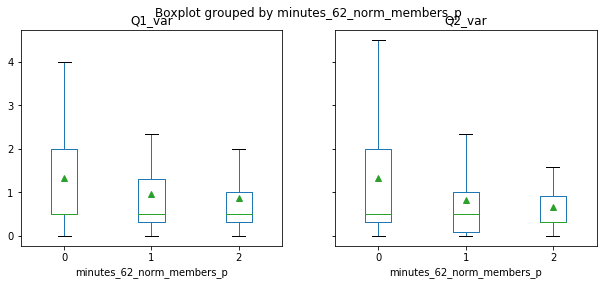

In [59]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_var", 'minutes_62_norm_members_p',[0],[2])

In [41]:
'''
data = company_dyads_daily_full_clean.copy()
data["g"]=-1
data.loc[data.minutes_62_norm_members < 50, 'g'] = 0
data.loc[data.minutes_62_norm_members > 100, 'g'] = 1
print(data.g.value_counts())

compare_groups(data,'g')
'''

'\ndata = company_dyads_daily_full_clean.copy()\ndata["g"]=-1\ndata.loc[data.minutes_62_norm_members < 50, \'g\'] = 0\ndata.loc[data.minutes_62_norm_members > 100, \'g\'] = 1\nprint(data.g.value_counts())\n\ncompare_groups(data,\'g\')\n'

### Count days of high interaction and low interaction

In [42]:
'''
data = company_dyads_daily_full_clean.copy()
data['quant'] = 1
data = data.groupby(['company','minutes_62_norm_members_p'])[['quant']].count().unstack().fillna(0)
data.columns = data.columns.droplevel(1)
data.columns = [0,1,2,3]

data['total']= data.sum(axis=1)
data['p0'] = data[0]/data['total']
data['p1'] = data[1]/data['total']
data['p2'] = data[2]/data['total']
data['p3'] = data[3]/data['total']
data['p01'] = data['p0'] + data['p1']
data['p23'] = data['p2'] + data['p3']
#del data['dummy']


data[['p01','p02']]
'''

"\ndata = company_dyads_daily_full_clean.copy()\ndata['quant'] = 1\ndata = data.groupby(['company','minutes_62_norm_members_p'])[['quant']].count().unstack().fillna(0)\ndata.columns = data.columns.droplevel(1)\ndata.columns = [0,1,2,3]\n\ndata['total']= data.sum(axis=1)\ndata['p0'] = data[0]/data['total']\ndata['p1'] = data[1]/data['total']\ndata['p2'] = data[2]/data['total']\ndata['p3'] = data[3]/data['total']\ndata['p01'] = data['p0'] + data['p1']\ndata['p23'] = data['p2'] + data['p3']\n#del data['dummy']\n\n\ndata[['p01','p02']]\n"

In [43]:
'''
company_dyads_annual_full_clean = pd.read_hdf(analysis_notebooks_store_path, 'shared_subjective_experience_2/company_dyads_annual_full_clean')
#company_dyads_annual_full_clean = daily_survey_data_clean.reset_index()
data = company_dyads_annual_full_clean.join(data[['p01','p23']])
'''

"\ncompany_dyads_annual_full_clean = pd.read_hdf(analysis_notebooks_store_path, 'shared_subjective_experience_2/company_dyads_annual_full_clean')\n#company_dyads_annual_full_clean = daily_survey_data_clean.reset_index()\ndata = company_dyads_annual_full_clean.join(data[['p01','p23']])\n"

In [44]:
'''
data["g"]=-1
data.loc[data.p01 <= 0.5, 'g'] = 0
data.loc[data.p01 > 0.5, 'g'] = 1
print(data.g.value_counts())

compare_groups(data,'g')
'''

'\ndata["g"]=-1\ndata.loc[data.p01 <= 0.5, \'g\'] = 0\ndata.loc[data.p01 > 0.5, \'g\'] = 1\nprint(data.g.value_counts())\n\ncompare_groups(data,\'g\')\n'

# Explore - between team

In [45]:
pairplot_columns = ['minutes_out_62','minutes_out_62_norm_members','minutes_out_62_norm_dyads','minutes_out_62_p','minutes_out_62_norm_members_p','minutes_out_62_norm_dyads_p']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std']+pairplot_columns

## plots

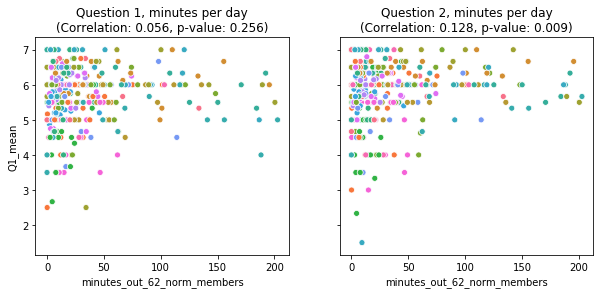

In [46]:
plot_corr(company_dyads_daily_full_clean,"_mean","minutes_out_62_norm_members","minutes per day")

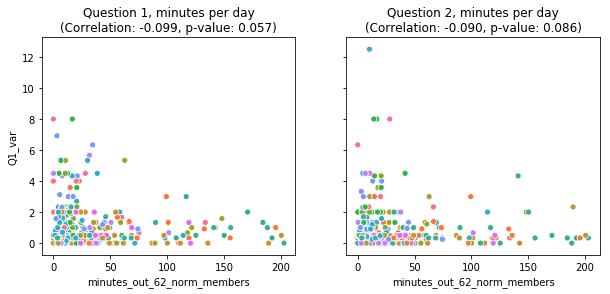

In [47]:
plot_corr(company_dyads_daily_full_clean.dropna(),"_var","minutes_out_62_norm_members","minutes per day")

## Correaltions

In [48]:
s = create_style_corr_table(company_dyads_daily_full_clean[q1_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q1_corr_daily_out.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q1 mean,Q1 min,Q1 var,Q1 std,minutes ou t 62,minutes ou t 62 norm members,minutes ou t 62 norm dyads,minutes ou t 62 p,minutes ou t 62 norm members p,minutes ou t 62 norm dyads p
Q1 mean,1,0.81,-0.36,-0.36,0.1,0.056,-0.02,0.17,0.078,-0.0067
Q1 min,0.81,1,-0.71,-0.75,0.045,0.07,0.082,0.058,0.084,0.088
Q1 var,-0.36,-0.71,1,0.92,-0.069,-0.1,-0.13,-0.074,-0.097,-0.11
Q1 std,-0.36,-0.75,0.92,1,-0.047,-0.098,-0.16,-0.068,-0.12,-0.12
minutes ou t 62,0.1,0.045,-0.069,-0.047,1,0.95,0.72,0.72,0.69,0.59
minutes ou t 62 norm members,0.056,0.07,-0.1,-0.098,0.95,1,0.88,0.67,0.7,0.67
minutes ou t 62 norm dyads,-0.02,0.082,-0.13,-0.16,0.72,0.88,1,0.54,0.64,0.68
minutes ou t 62 p,0.17,0.058,-0.074,-0.068,0.72,0.67,0.54,1,0.86,0.65
minutes ou t 62 norm members p,0.078,0.084,-0.097,-0.12,0.69,0.7,0.64,0.86,1,0.84
minutes ou t 62 norm dyads p,-0.0067,0.088,-0.11,-0.12,0.59,0.67,0.68,0.65,0.84,1


In [49]:
s = create_style_corr_table(company_dyads_daily_full_clean[q2_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q2_corr_daily_out.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q2 mean,Q2 min,Q2 var,Q2 std,minutes ou t 62,minutes ou t 62 norm members,minutes ou t 62 norm dyads,minutes ou t 62 p,minutes ou t 62 norm members p,minutes ou t 62 norm dyads p
Q2 mean,1,0.84,-0.39,-0.38,0.16,0.13,0.056,0.23,0.14,0.065
Q2 min,0.84,1,-0.68,-0.74,0.11,0.13,0.12,0.15,0.14,0.14
Q2 var,-0.39,-0.68,1,0.91,-0.086,-0.09,-0.1,-0.11,-0.096,-0.072
Q2 std,-0.38,-0.74,0.91,1,-0.068,-0.097,-0.15,-0.11,-0.12,-0.12
minutes ou t 62,0.16,0.11,-0.086,-0.068,1,0.95,0.72,0.72,0.69,0.59
minutes ou t 62 norm members,0.13,0.13,-0.09,-0.097,0.95,1,0.88,0.67,0.7,0.67
minutes ou t 62 norm dyads,0.056,0.12,-0.1,-0.15,0.72,0.88,1,0.54,0.64,0.68
minutes ou t 62 p,0.23,0.15,-0.11,-0.11,0.72,0.67,0.54,1,0.86,0.65
minutes ou t 62 norm members p,0.14,0.14,-0.096,-0.12,0.69,0.7,0.64,0.86,1,0.84
minutes ou t 62 norm dyads p,0.065,0.14,-0.072,-0.12,0.59,0.67,0.68,0.65,0.84,1


## Compare populations

1    127
2    125
0    115
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 115 , 125
Q1, p: 0.08, Means: 5.58 (0.07),5.73 (0.07), medians: 5.67,6.00
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.01, Means: 5.67 (0.08),5.95 (0.05), medians: 5.88,6.00
--- KS test - Q2: group a: 0.00   group b: 0.00


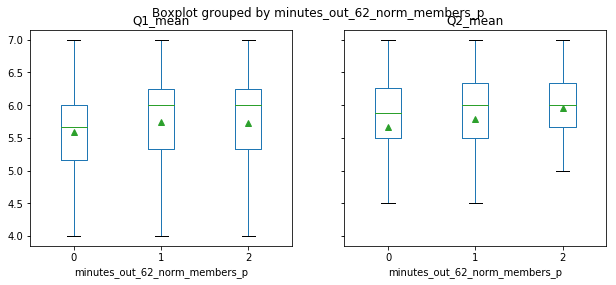

In [50]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_mean", 'minutes_out_62_norm_members_p',[0],[2])
#compare_groups(company_dyads_daily_full_clean.dropna(),"_mean", 'minutes_out_62_norm_members_p',[0],[1,2])# - ok with ttest

1    127
2    125
0    115
Name: minutes_out_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 115 , 125
Q1, p: 0.01, Means: 1.13 (0.13),0.83 (0.10), medians: 0.50,0.50
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.01, Means: 0.93 (0.11),0.62 (0.07), medians: 0.50,0.33
--- KS test - Q2: group a: 0.00   group b: 0.00


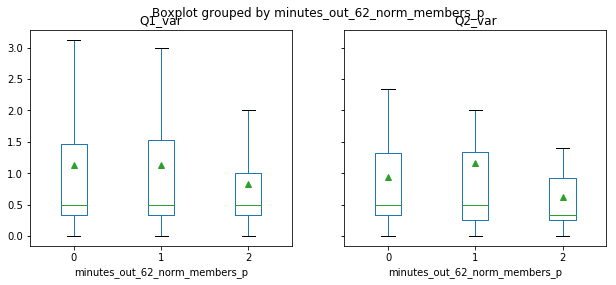

In [51]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_var", 'minutes_out_62_norm_members_p',[0],[2])

# Explore - EIR

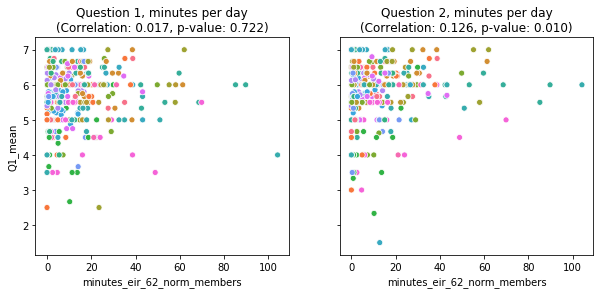

In [52]:
plot_corr(company_dyads_daily_full_clean,"_mean","minutes_eir_62_norm_members","minutes per day")

In [53]:
pairplot_columns = ['minutes_eir_62','minutes_eir_62_norm_members','minutes_eir_62_norm_dyads','minutes_eir_62_p','minutes_eir_62_norm_members_p','minutes_eir_62_norm_dyads_p']
q1_columns = ['Q1_mean','Q1_min','Q1_var','Q1_std']+pairplot_columns
q2_columns = ['Q2_mean','Q2_min','Q2_var','Q2_std']+pairplot_columns

In [54]:
s = create_style_corr_table(company_dyads_daily_full_clean[q1_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q1_corr_daily_eir.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q1 mean,Q1 min,Q1 var,Q1 std,minutes ei r 62,minutes ei r 62 norm members,minutes ei r 62 norm dyads,minutes ei r 62 p,minutes ei r 62 norm members p,minutes ei r 62 norm dyads p
Q1 mean,1,0.81,-0.36,-0.36,0.079,0.017,-0.073,0.11,0.063,0.022
Q1 min,0.81,1,-0.71,-0.75,0.0082,0.032,0.031,0.023,0.054,0.064
Q1 var,-0.36,-0.71,1,0.92,-0.053,-0.083,-0.11,-0.088,-0.14,-0.14
Q1 std,-0.36,-0.75,0.92,1,-0.0073,-0.062,-0.12,-0.057,-0.12,-0.13
minutes ei r 62,0.079,0.0082,-0.053,-0.0073,1,0.93,0.67,0.77,0.73,0.66
minutes ei r 62 norm members,0.017,0.032,-0.083,-0.062,0.93,1,0.88,0.7,0.72,0.71
minutes ei r 62 norm dyads,-0.073,0.031,-0.11,-0.12,0.67,0.88,1,0.52,0.61,0.64
minutes ei r 62 p,0.11,0.023,-0.088,-0.057,0.77,0.7,0.52,1,0.89,0.8
minutes ei r 62 norm members p,0.063,0.054,-0.14,-0.12,0.73,0.72,0.61,0.89,1,0.91
minutes ei r 62 norm dyads p,0.022,0.064,-0.14,-0.13,0.66,0.71,0.64,0.8,0.91,1


In [55]:
s = create_style_corr_table(company_dyads_daily_full_clean[q2_columns])
imgkit.from_string(s.render(), '/home/orenled/temp/q2_corr_daily_eir.png')
s

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Q2 mean,Q2 min,Q2 var,Q2 std,minutes ei r 62,minutes ei r 62 norm members,minutes ei r 62 norm dyads,minutes ei r 62 p,minutes ei r 62 norm members p,minutes ei r 62 norm dyads p
Q2 mean,1,0.84,-0.39,-0.38,0.17,0.13,0.031,0.17,0.14,0.11
Q2 min,0.84,1,-0.68,-0.74,0.13,0.14,0.1,0.11,0.14,0.15
Q2 var,-0.39,-0.68,1,0.91,-0.11,-0.09,-0.063,-0.15,-0.16,-0.16
Q2 std,-0.38,-0.74,0.91,1,-0.1,-0.12,-0.13,-0.12,-0.15,-0.17
minutes ei r 62,0.17,0.13,-0.11,-0.1,1,0.93,0.67,0.77,0.73,0.66
minutes ei r 62 norm members,0.13,0.14,-0.09,-0.12,0.93,1,0.88,0.7,0.72,0.71
minutes ei r 62 norm dyads,0.031,0.1,-0.063,-0.13,0.67,0.88,1,0.52,0.61,0.64
minutes ei r 62 p,0.17,0.11,-0.15,-0.12,0.77,0.7,0.52,1,0.89,0.8
minutes ei r 62 norm members p,0.14,0.14,-0.16,-0.15,0.73,0.72,0.61,0.89,1,0.91
minutes ei r 62 norm dyads p,0.11,0.15,-0.16,-0.17,0.66,0.71,0.64,0.8,0.91,1


2    129
1    128
0    110
Name: minutes_eir_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 110 , 129
Q1, p: 0.03, Means: 5.63 (0.07),5.77 (0.07), medians: 5.67,6.00
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.00, Means: 5.67 (0.08),5.97 (0.07), medians: 6.00,6.00
--- KS test - Q2: group a: 0.00   group b: 0.00


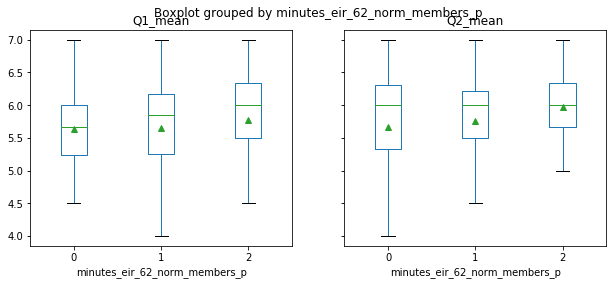

In [56]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_mean", 'minutes_eir_62_norm_members_p',[0],[2])

2    129
1    128
0    110
Name: minutes_eir_62_norm_members_p, dtype: int64
Test: <function mannwhitneyu at 0x7f44bb06eaa0>
Group sizes:  , 110 , 129
Q1, p: 0.03, Means: 1.29 (0.15),0.83 (0.09), medians: 0.50,0.50
--- KS test - Q1: group a: 0.00   group b: 0.00
Q2, p: 0.00, Means: 1.23 (0.17),0.69 (0.09), medians: 0.50,0.33
--- KS test - Q2: group a: 0.00   group b: 0.00


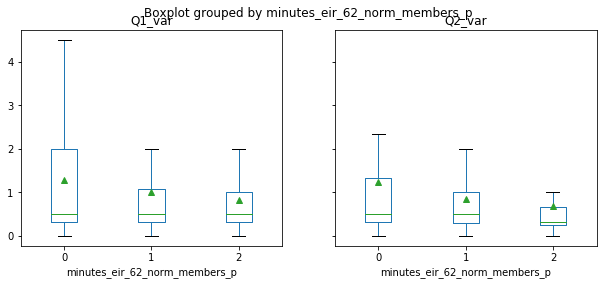

In [57]:
compare_groups(company_dyads_daily_full_clean.dropna(),"_var", 'minutes_eir_62_norm_members_p',[0],[2])

# Misc